In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, Sigmoid, Module
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [2]:
# Creating Circuit

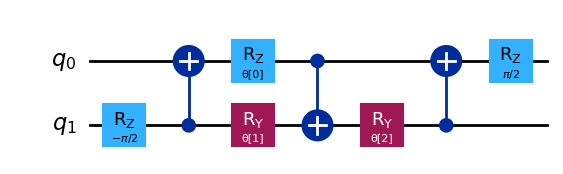

In [3]:
# Two qubit unitary as defined
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

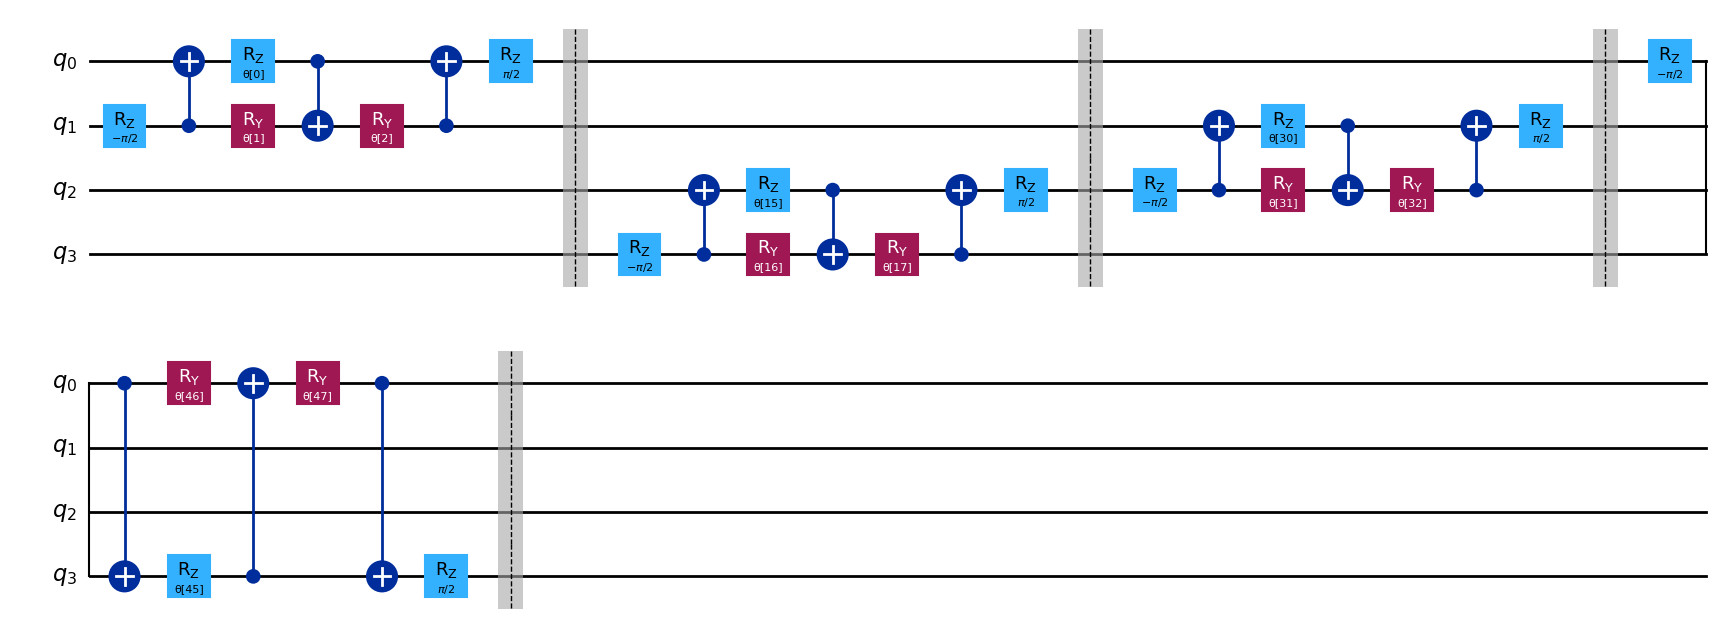

In [4]:
# Create Layer (Repeating Circuit on Neighboring Qubits).
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Visual
circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

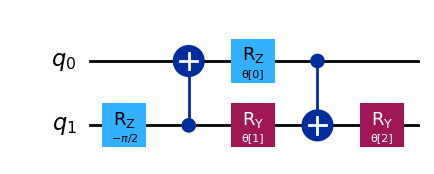

In [5]:
# Defining Pool Circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

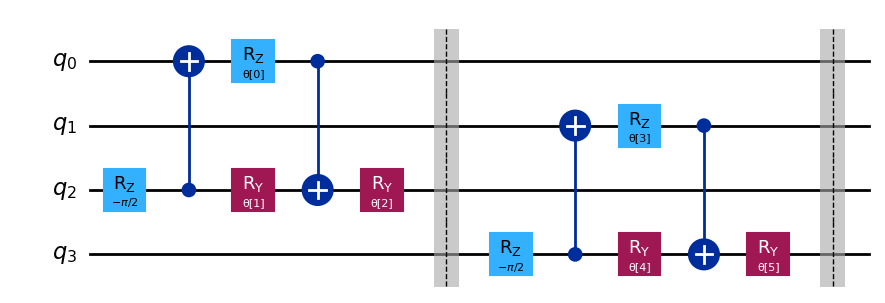

In [6]:
# Defining Pool Layer (Repeating Circuit on Neighboring Qubits)
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Visual
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

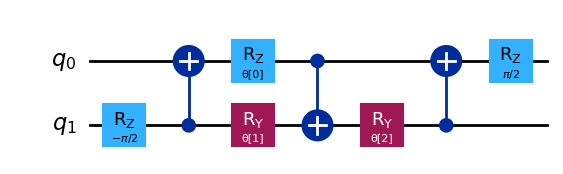

In [7]:
# Two qubit unitary as defined
def FC(params, qubits):
    target = QuantumCircuit(qubits.length)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

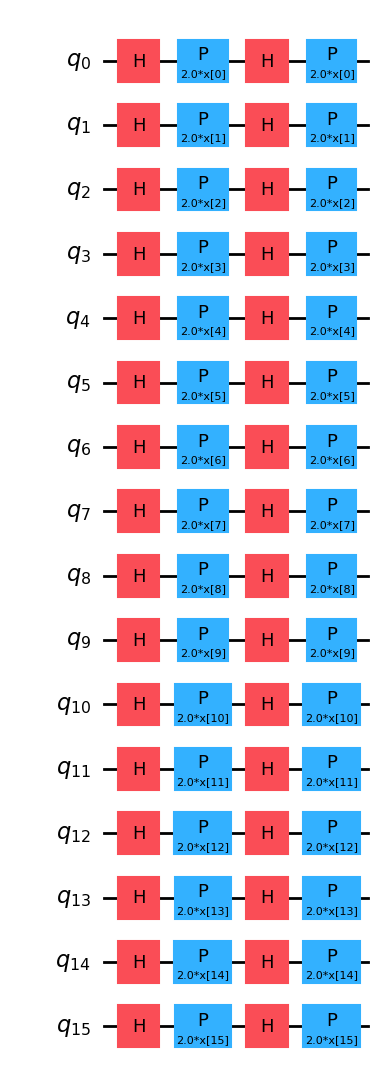

In [8]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

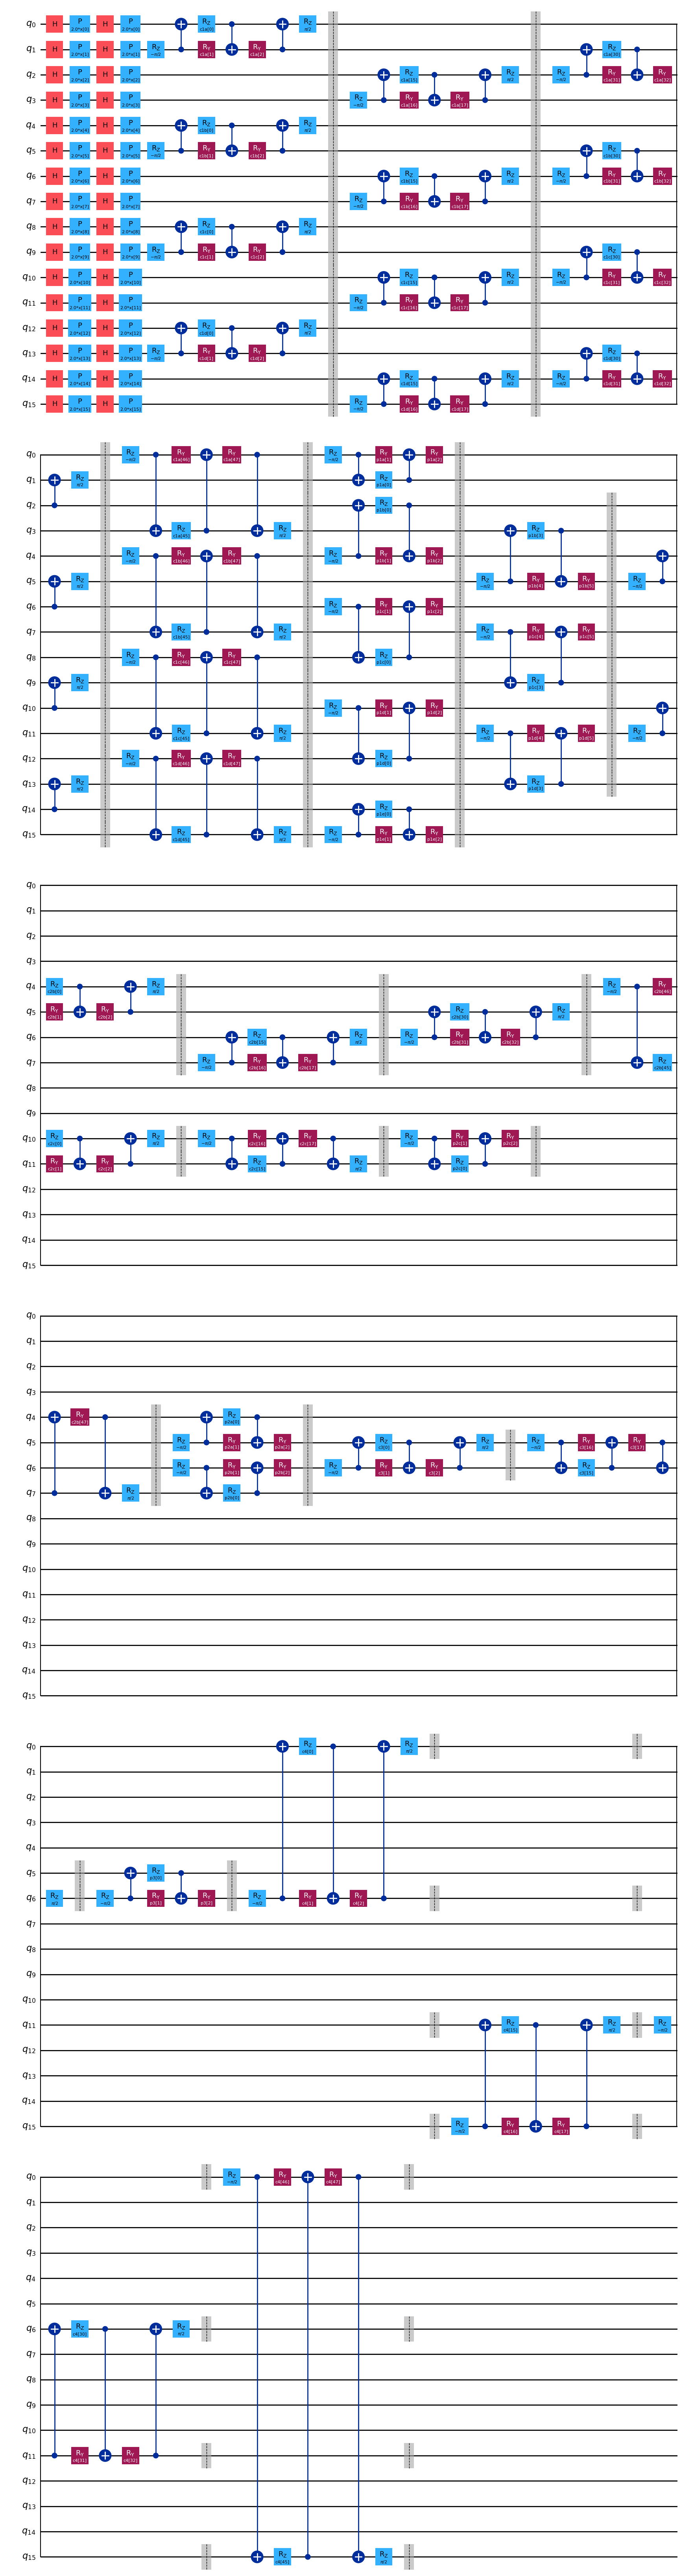

In [9]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    # First Convolutional Layer Set
    ansatz.compose(conv_layer(4, "с1a"), list(range(4)), inplace=True)
    ansatz.compose(conv_layer(4, "с1b"), list(range(4,8)), inplace=True)
    ansatz.compose(conv_layer(4, "с1c"), list(range(8,12)), inplace=True)
    ansatz.compose(conv_layer(4, "с1d"), list(range(12,16)), inplace=True)
    
    # First Pooling Layer Set
    ansatz.compose(pool_layer([1], [0], "p1a"), list(range(2)), inplace=True)
    ansatz.compose(pool_layer([0, 1], [2,3], "p1b"), list(range(2,6)), inplace=True)
    ansatz.compose(pool_layer([2, 3], [0,1], "p1c"), list(range(6,10)), inplace=True)
    ansatz.compose(pool_layer([2, 3], [0,1], "p1d"), list(range(10,14)), inplace=True)
    ansatz.compose(pool_layer([0], [1], "p1e"), list(range(14,16)), inplace=True)

    # Second Convolutional Layer Set
    # ansatz.compose(conv_layer(1, "с2a"), list(0), inplace=True)
    ansatz.compose(conv_layer(4, "с2b"), list(range(4,8)), inplace=True)
    ansatz.compose(conv_layer(2, "с2c"), list(range(10,12)), inplace=True)
    # ansatz.compose(conv_layer(1, "с2d"), list(15), inplace=True)

    # Second Pooling Layer Set
    ansatz.compose(pool_layer([0], [1], "p2a"), list(range(4,6)), inplace=True)
    ansatz.compose(pool_layer([1], [0], "p2b"), list(range(6,8)), inplace=True)
    ansatz.compose(pool_layer([1], [0], "p2c"), list(range(10,12)), inplace=True)

    # Third Convolutional Layer Set
    ansatz.compose(conv_layer(2, "с3"), list(range(5,7)), inplace=True)

    # Third Pooling Layer Set
    ansatz.compose(pool_layer([0], [1], "p3"), list(range(5,7)), inplace=True)

    # Quantum Connected Layer
    ansatz.compose(conv_layer(4, "с4"), list([0,6,11,15]), inplace=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().decompose().draw("mpl"))

In [10]:
# Creating/Formatting Data

In [11]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-11 11:44:51.457128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733946291.470318    9041 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733946291.475000    9041 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 11:44:51.487383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [12]:
# Filter Values
a = 3
b = 4
c = 5
d = 6
def filter_abcd(x, y):
    keep = (y == a) | (y == b) | (y == c) | (y == d)
    x, y = x[keep], y[keep]
    return x,y

In [13]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 23312
Number of filtered test examples: 3842


6


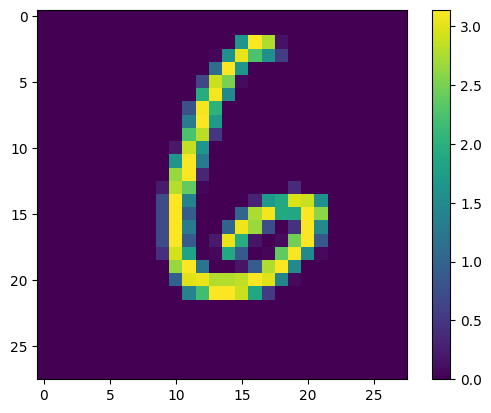

In [14]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [15]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1733946293.495728    9041 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20724 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


6


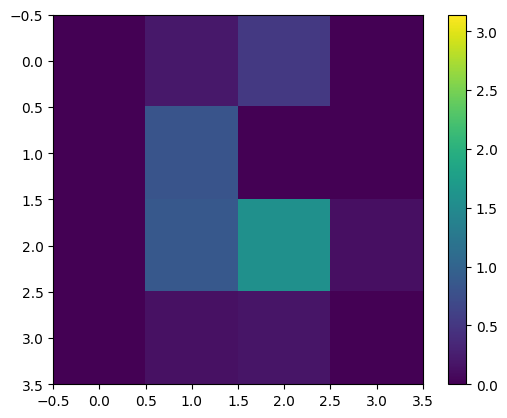

In [16]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [17]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
        elif entry == c:
            y_temp.append(2)
        elif entry == d:
            y_temp.append(3)
    return y_temp

In [18]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:128]
y = y[0:128]
x1 = x1[0:128]
y1 = y1[0:128]
print(x)
print(y)

[[0.         0.19058241 0.5850729  ... 1.2083628  0.15663964 0.        ]
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 ...
 [0.         0.21999948 1.2091172  ... 0.9302835  0.07215983 0.        ]
 [0.         0.00553142 0.68262696 ... 0.99364346 0.57375866 0.        ]
 [0.         0.         0.17826243 ... 0.16342819 0.2768222  0.        ]]
[2 1 0 1 0 2 0 3 3 1 1 0 0 3 2 3 3 0 2 0 0 1 1 1 1 3 1 2 3 3 0 3 0 1 3 1 3
 0 2 3 0 0 1 3 1 3 0 1 2 0 0 2 1 1 2 3 0 1 3 3 0 1 1 3 1 2 2 0 0 2 3 2 1 0
 0 3 0 0 1 3 2 3 1 0 0 2 1 3 2 3 0 2 0 0 0 3 1 2 3 2 1 1 2 3 1 2 0 0 2 3 2
 1 0 1 1 1 0 3 3 2 3 1 2 0 3 0 2 1]


In [19]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    countc = 0
    countd = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        elif y[i] == 2:
            countc+=1
        elif y[i] == 3:
            countd+=1
    return(counta, countb, countc, countd)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [20]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (36, 34, 26, 32)
max_count = 26
balanced: (26, 26, 26, 26)
shuffled: (26, 26, 26, 26)
final: [[0.         0.02137138 1.036889   ... 0.21396522 0.15412535 0.        ]
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.         0.00226285 ... 0.50713027 0.23961087 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.29894787 ... 0.2883879  0.09101693 0.        ]
 [0.         0.51794165 0.5870843  ... 0.6841355  0.79099244 0.        ]]
[3 1 2 1 2 2 1 0 3 0 0 3 0 2 0 1 2 2 2 1 3 0 3 0 2 3 3 2 1 0 1 3 2 3 1 1 1
 3 0 2 1 0 1 0 3 2 1 3 1 0 2 0 2 2 3 3 2 0 3 2 2 0 1 0 3 2 2 1 1 2 1 3 3 1
 2 1 0 3 1 1 1 3 3 0 0 1 2 0 1 3 0 0 3 0 0 3 3 3 0 0 2 2 1 2]


In [21]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [22]:
# One-Hot Encoding for Final Processing
num_classes = 4
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [23]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.0214, 1.0369,  ..., 0.2140, 0.1541, 0.0000],
        [0.0360, 0.0000, 0.0470,  ..., 0.0000, 0.5469, 0.0000],
        [0.0000, 0.0000, 0.0023,  ..., 0.5071, 0.2396, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2989,  ..., 0.2884, 0.0910, 0.0000],
        [0.0000, 0.5179, 0.5871,  ..., 0.6841, 0.7910, 0.0000]],
       device='cuda:0') tensor([[0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
      

In [24]:
# Training

In [25]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.softmax(x)
        return x

In [26]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

# Setting observables on 15th and 16th qubits.
observable_z16 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observable_z12 = SparsePauliOp.from_sparse_list([("Z", [11], 1)], num_qubits=num_qubits)
observable_z7 = SparsePauliOp.from_sparse_list([("Z", [6], 1)], num_qubits=num_qubits)
observable_z1 = SparsePauliOp.from_sparse_list([("Z", [0], 1)], num_qubits=num_qubits)
observables = [observable_z1, observable_z7, observable_z12, observable_z16]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
    input_gradients = True,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_9041/1645403222.py:24: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_9041/1645403222.py:24: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[-0.03710938,  0.07226562, -0.07226562,  0.04296875],
       [-0.08398438,  0.0703125 , -0.06640625,  0.10546875],
       [-0.09960938,  0.14257812, -0.15625   ,  0.24414062],
       [-0.06640625,  0.1171875 , -0.07421875,  0.11914062],
       [-0.15234375,  0.13476562, -0.16210938,  0.22851562],
       [-0.140625  ,  0.20507812, -0.09179688,  0.1953125 ],
       [-0.12109375,  0.09960938, -0.05859375,  0.01757812],
       [-0.1171875 ,  0.18359375, -0.10546875,  0.19726562],
       [-0.109375  ,  0.07226562, -0.09960938,  0.08789062],
       [-0.109375  ,  0.140625  , -0.11914062,  0.09179688],
       [-0.05859375,  0.03320312, -0.04296875, -0.00585938],
       [-0.11132812,  0.1015625 , -0.04882812,  0.12695312],
       [-0.07226562,  0.1484375 , -0.05664062,  0.08398438],
       [-0.12304688,  0.171875  , -0.08203125,  0.21679688],
       [-0.08203125,  0.07617188, -0.11523438,  0.0625    ],
       [-0.12109375,  0.13867188, -0.02734375,  0.05273438],
       [-0.13867188,  0.

In [27]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [28]:
# We want to supply one-hot encoded labels.
from tensorflow.keras.losses import CategoricalCrossentropy
loss_func = CategoricalCrossentropy()

# Callback Helper Functions
def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (torch.argmax(val) == torch.argmax(Y[i])):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

def objective_function(weights):
    global X
    global Y
    if(i != 1 and i%333 == 0):
        indices = torch.randperm(X.size()[0])
        X=X[indices]
        Y=Y[indices]
        print(X,Y)
    # Referencing Global Variables
    global data
    # Local Variable
    total_loss = 0.0
    # Overiding with new data
    model = Model(TorchConnector(estimator, weights)).to("cuda")
    # Getting Output
    output = model(X)
    loss_output = output.detach().cpu().numpy()
    loss_Y = Y.detach().cpu().numpy()
    # Calculate Loss
    loss = loss_func(loss_output, loss_Y).numpy()
    # Append Checkpoint Data Points to Tracker
    val = f"Iteration: {i}; Accuracy: {accuracy(output, Y)}%; Loss: {loss}"
    data.append(val)
    total_loss += loss
    loss_list.append(total_loss)
    return total_loss

def callback(weights):
    # Iteration Tracking
    global i
    global weight_list
    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))
    # Plotting Loss Function
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()
    # Printing Weights
    weight_list.append(weights)
    print(weights)
    # Iteration Counter
    i+=1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

In [29]:
# Training Function
def fit(weights=None, losslist=None, iter= 1000, fresh_start = False):
    global i
    global data
    global weight_list
    global loss_list
    if(fresh_start):
        loss_list = []
        data = []
        weight_list = []
        weights = algorithm_globals.random.random(estimator.num_weights)
        i = 1
    else:
        if 'data' not in globals(): data = []
        else: data = data
        if 'weight_list' not in globals():weight_list = []
        else: weight_list = weight_list
        if 'i' not in globals() and 'i' not in locals(): i = 1
        else: i = i
        if losslist is not None: losslist = losslist
        elif (('loss_list' not in globals() and 'loss_list' not in locals()) and losslist == None): loss_list = []
        elif 'loss_list' not in globals() and 'loss_list' not in locals(): loss_list = losslist
        else: loss_list = loss_list
        if weights is not None: weights = weights
        elif (('result' not in locals() and 'result' not in globals())) and weights == None:
            weights = algorithm_globals.random.random(estimator.num_weights)
        elif (len(weight_list)>0):
            weights = weight_list[-1]
        else:
            weights = result[0].x
            loss_list = result[2]
    
    result = minimize(
        fun=objective_function,
        callback = callback,
        x0=weights,
        method='COBYLA',
        options={'maxiter': iter},
    )
    return result, data, loss_list, weight_list

Iteration: 1; Accuracy: 39.42307692307692%; Loss: 11.965337753295898
Iteration: 2; Accuracy: 36.53846153846153%; Loss: 11.95168685913086
Iteration: 3; Accuracy: 35.57692307692308%; Loss: 11.971858978271484
Iteration: 4; Accuracy: 36.53846153846153%; Loss: 11.95168685913086
Iteration: 5; Accuracy: 37.5%; Loss: 11.97507095336914
Iteration: 6; Accuracy: 39.42307692307692%; Loss: 11.967947006225586
Iteration: 7; Accuracy: 36.53846153846153%; Loss: 11.95168685913086
Iteration: 8; Accuracy: 37.5%; Loss: 11.987128257751465
Iteration: 9; Accuracy: 38.46153846153847%; Loss: 11.987980842590332
Iteration: 10; Accuracy: 36.53846153846153%; Loss: 11.95168685913086
Iteration: 11; Accuracy: 36.53846153846153%; Loss: 11.9678955078125
Iteration: 12; Accuracy: 37.5%; Loss: 11.965712547302246
Iteration: 13; Accuracy: 36.53846153846153%; Loss: 11.95168685913086
Iteration: 14; Accuracy: 40.38461538461539%; Loss: 11.968761444091797
Iteration: 15; Accuracy: 41.34615384615385%; Loss: 11.953775405883789
Iterat

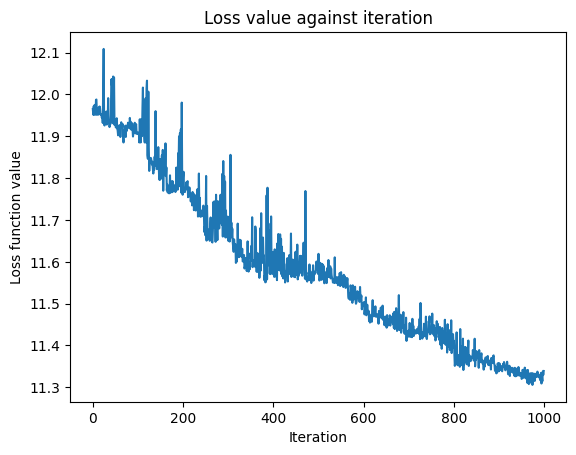

[ 9.64460361e-01  4.88127395e-02  1.38005734e+00  2.35508350e+00
  1.56400536e+00  2.33202903e-01  1.10926317e+00 -9.35485029e-01
 -4.01498492e-01 -5.35192588e-01  9.24853981e-01 -4.29746069e-01
  1.32385521e+00  7.36424334e-02  1.14552657e+00  5.77327544e-01
  1.25391397e+00  6.83710731e-01  1.18201249e+00  2.09763519e+00
  8.16448674e-01  1.23477096e+00  3.16728163e-02 -6.06439769e-02
  1.88499550e+00  2.56307657e+00  3.83870947e-01  4.14331816e-01
  1.54731634e+00 -1.71593388e-01  8.97403152e-01  4.31087902e-01
 -1.27410340e-01 -3.40324455e-01  1.21480407e+00  8.21025876e-02
  1.77942090e+00  1.01172414e+00  1.73410557e+00  4.04044429e-02
  1.78744764e-01  7.15133211e-01  6.61806880e-02 -6.89665164e-02
  1.61634947e-01 -1.06979296e-01 -2.43104368e-01 -5.72763016e-04
  5.19775286e-01  1.03237956e+00  1.09178919e+00 -1.69663964e-01
  4.17005194e-01  2.47746646e+00  1.94764544e+00  1.14982476e+00
 -7.31853189e-01  8.47092536e-01  7.34610345e-01  6.63708206e-01
  1.67031191e+00  1.11844

In [30]:
# Call Training Function and Save as Result
result = fit(iter=1000, fresh_start=False)

In [31]:
savemodel = Model(TorchConnector(estimator, result[0].x))
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "4Classes_Circuit4B")

True


In [32]:
evalmodel = torch.load("4Classes_Circuit4B", weights_only=False).to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 51.92307692307693%
Test Accuracy: 42.96875%


In [33]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(3, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2,

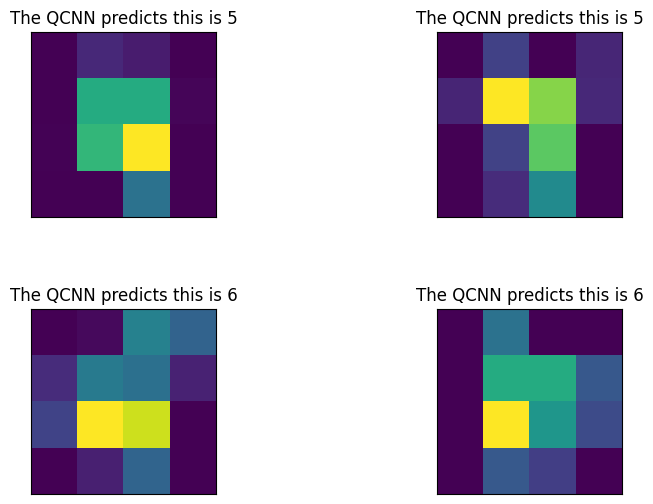

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output1[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output1[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
    if torch.argmax(output1[i]) == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 5")
    if torch.argmax(output1[i]) == 3:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 6")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

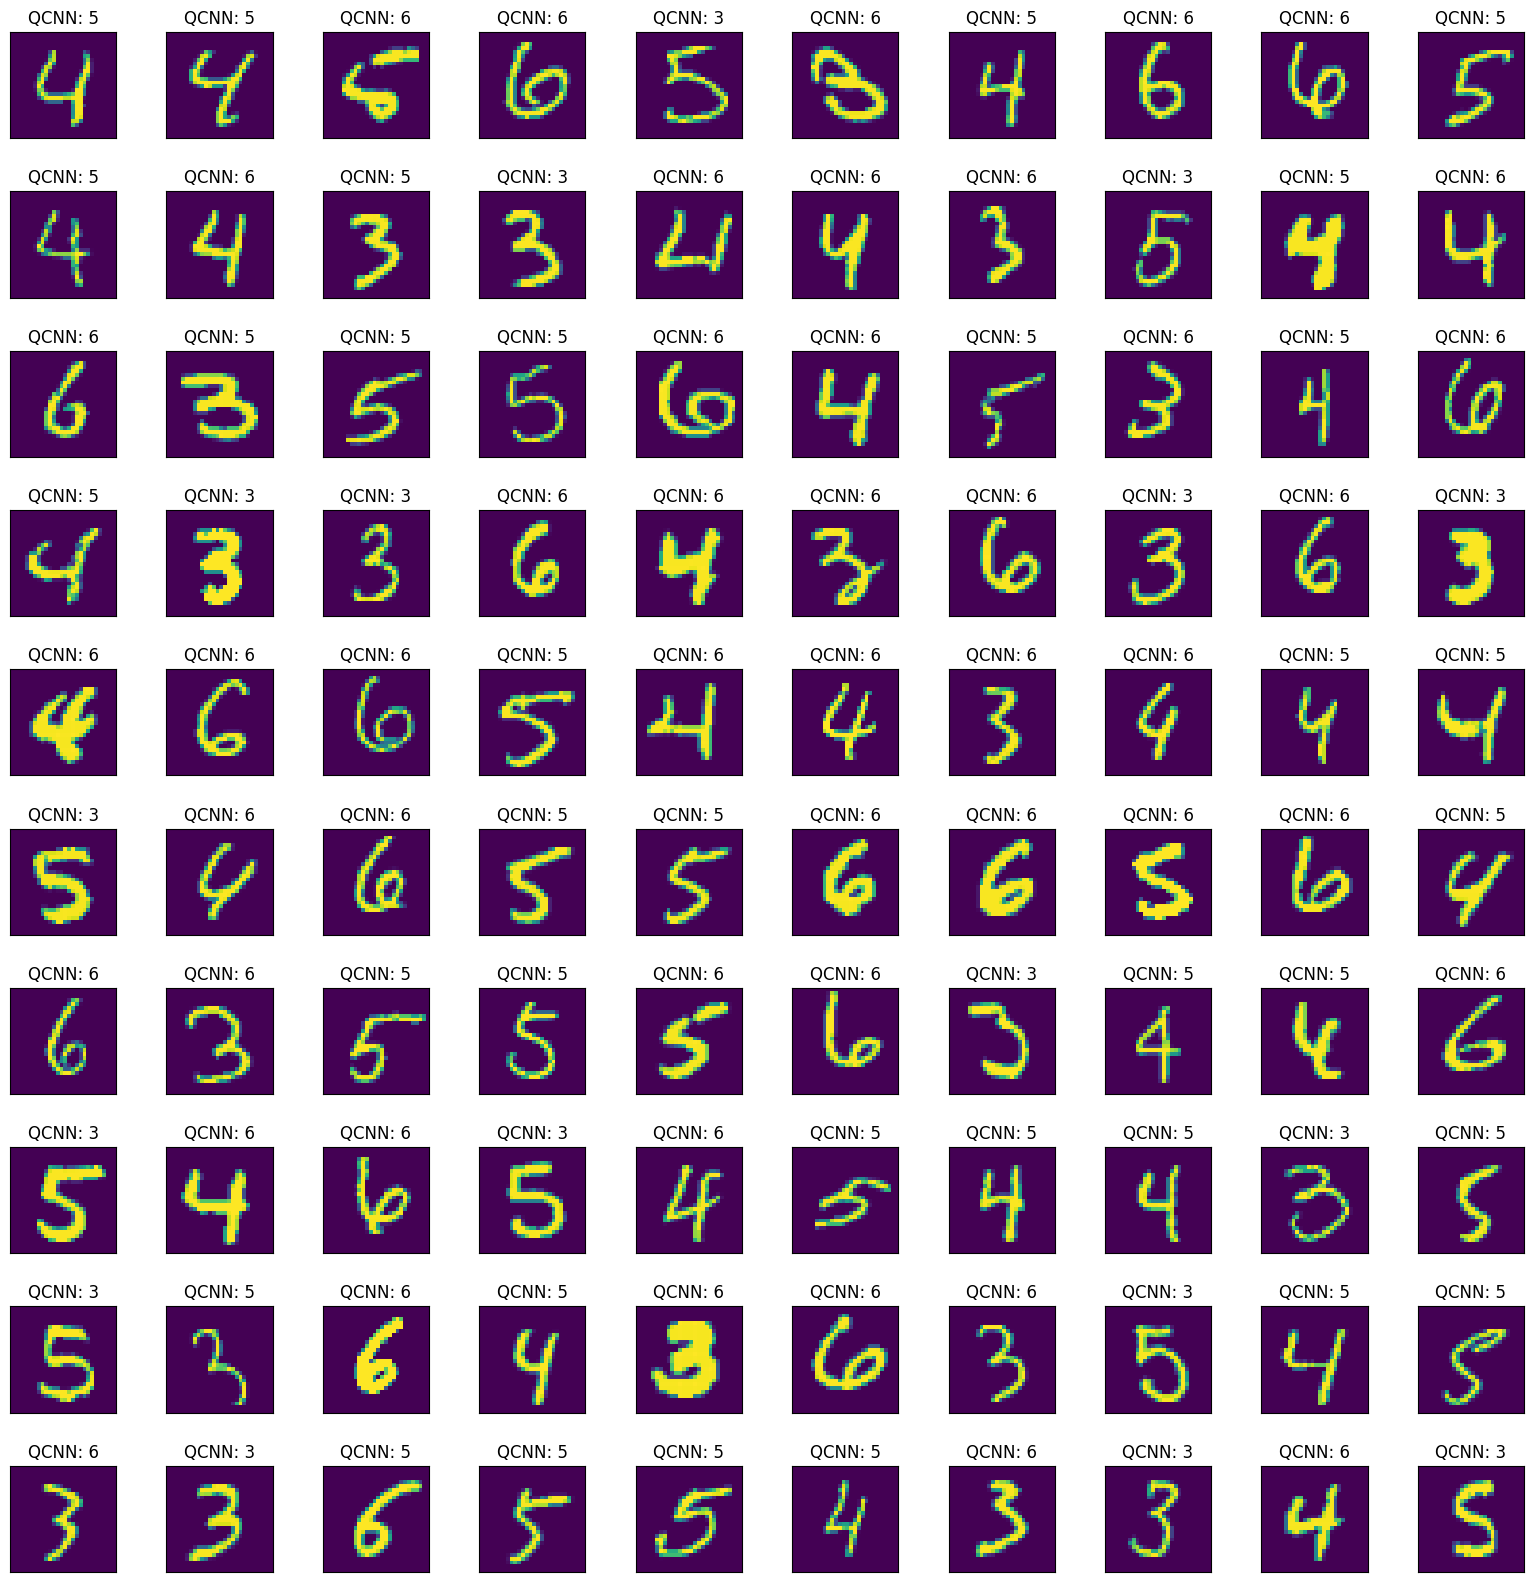

In [35]:
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20),
                       subplot_kw={"xticks": [], "yticks": []})

for i in range(num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    
    if i < len(x_test) and i < len(output1):
      ax[row, col].imshow(x_test[i].reshape(28, 28), aspect="equal")

      if torch.argmax(output1[i]) == 0:
          ax[row, col].set_title("QCNN: 3")
      elif torch.argmax(output1[i]) == 1:
          ax[row, col].set_title("QCNN: 4")
      elif torch.argmax(output1[i]) == 2:
          ax[row, col].set_title("QCNN: 5")
      elif torch.argmax(output1[i]) == 3:
          ax[row, col].set_title("QCNN: 6")
    else:
        ax[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

In [36]:
print(result)

( message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 11.305652618408203
       x: [ 9.645e-01  4.881e-02 ... -1.409e-01 -1.709e-01]
    nfev: 1000
   maxcv: 0.0, ['Iteration: 1; Accuracy: 39.42307692307692%; Loss: 11.965337753295898', 'Iteration: 2; Accuracy: 36.53846153846153%; Loss: 11.95168685913086', 'Iteration: 3; Accuracy: 35.57692307692308%; Loss: 11.971858978271484', 'Iteration: 4; Accuracy: 36.53846153846153%; Loss: 11.95168685913086', 'Iteration: 5; Accuracy: 37.5%; Loss: 11.97507095336914', 'Iteration: 6; Accuracy: 39.42307692307692%; Loss: 11.967947006225586', 'Iteration: 7; Accuracy: 36.53846153846153%; Loss: 11.95168685913086', 'Iteration: 8; Accuracy: 37.5%; Loss: 11.987128257751465', 'Iteration: 9; Accuracy: 38.46153846153847%; Loss: 11.987980842590332', 'Iteration: 10; Accuracy: 36.53846153846153%; Loss: 11.95168685913086', 'Iteration: 11; Accuracy: 36.53846153846153%; Loss: 11.9678955078125', 'Iteration: 12; Accura

In [37]:
# Iteration Value Display Error (Skips back to 3)
result[1]

['Iteration: 1; Accuracy: 39.42307692307692%; Loss: 11.965337753295898',
 'Iteration: 2; Accuracy: 36.53846153846153%; Loss: 11.95168685913086',
 'Iteration: 3; Accuracy: 35.57692307692308%; Loss: 11.971858978271484',
 'Iteration: 4; Accuracy: 36.53846153846153%; Loss: 11.95168685913086',
 'Iteration: 5; Accuracy: 37.5%; Loss: 11.97507095336914',
 'Iteration: 6; Accuracy: 39.42307692307692%; Loss: 11.967947006225586',
 'Iteration: 7; Accuracy: 36.53846153846153%; Loss: 11.95168685913086',
 'Iteration: 8; Accuracy: 37.5%; Loss: 11.987128257751465',
 'Iteration: 9; Accuracy: 38.46153846153847%; Loss: 11.987980842590332',
 'Iteration: 10; Accuracy: 36.53846153846153%; Loss: 11.95168685913086',
 'Iteration: 11; Accuracy: 36.53846153846153%; Loss: 11.9678955078125',
 'Iteration: 12; Accuracy: 37.5%; Loss: 11.965712547302246',
 'Iteration: 13; Accuracy: 36.53846153846153%; Loss: 11.95168685913086',
 'Iteration: 14; Accuracy: 40.38461538461539%; Loss: 11.968761444091797',
 'Iteration: 15; Acc